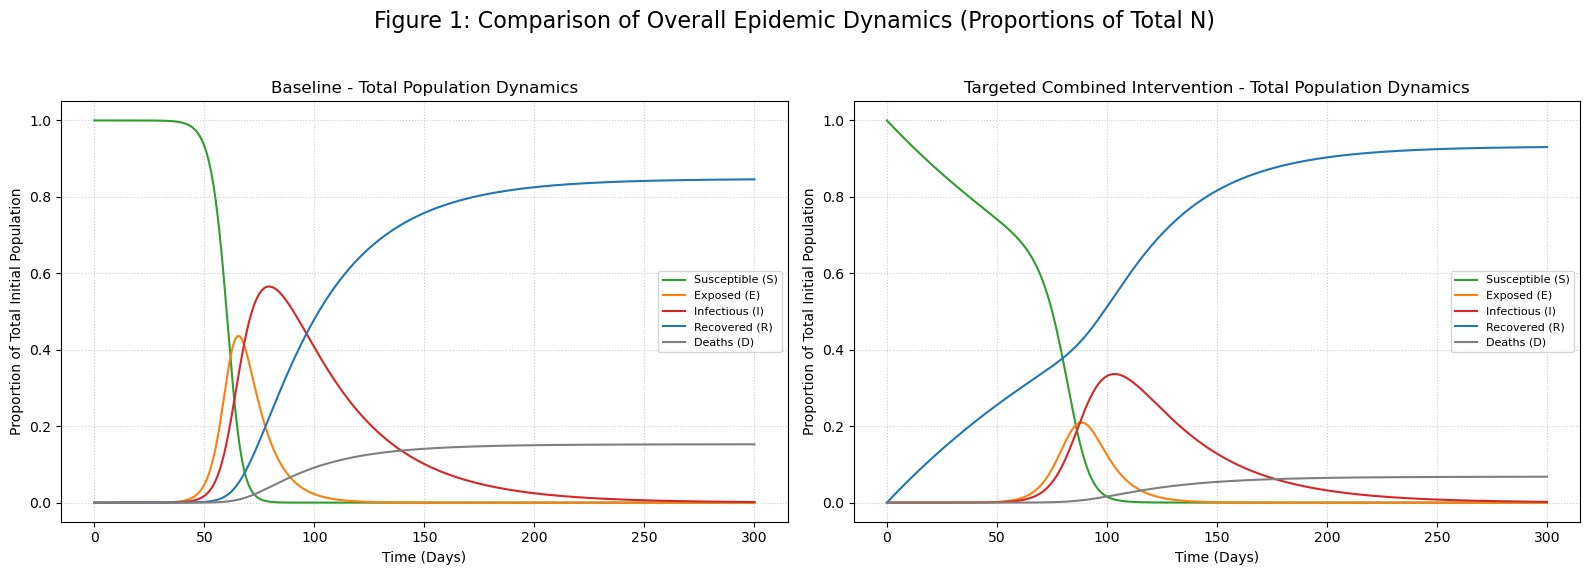

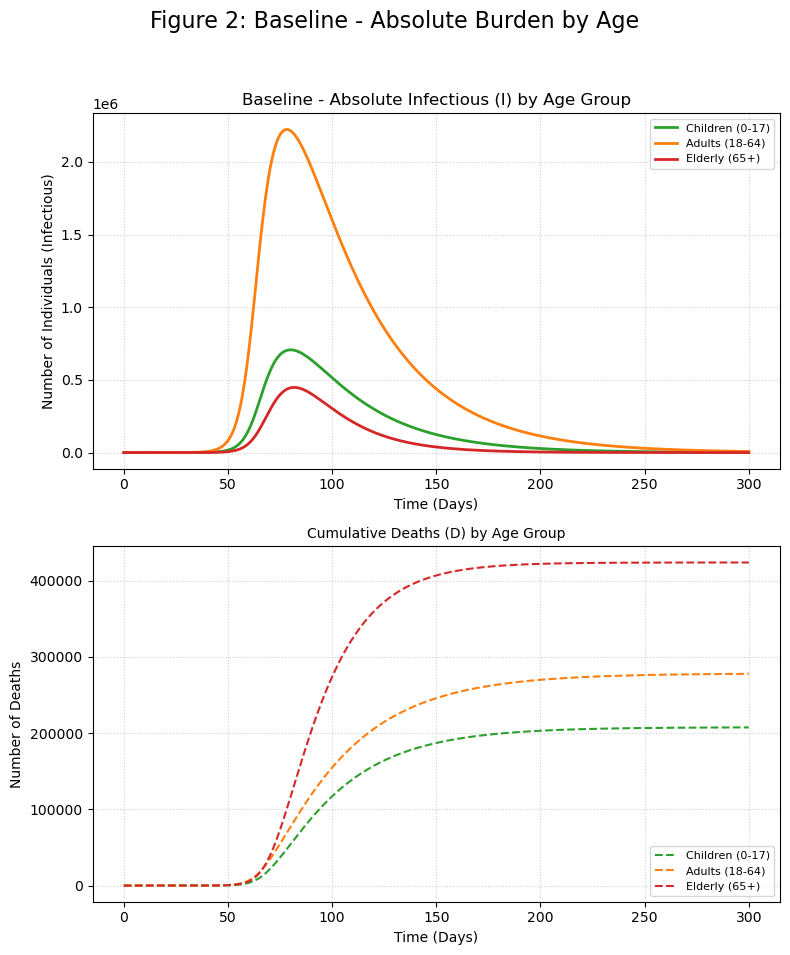

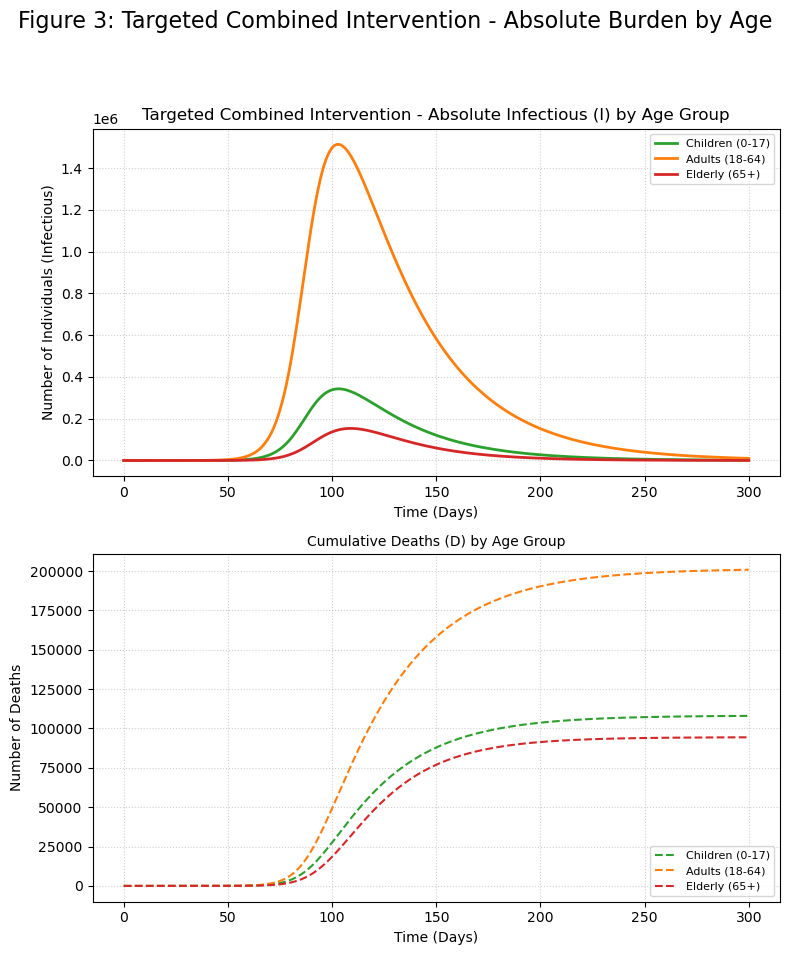

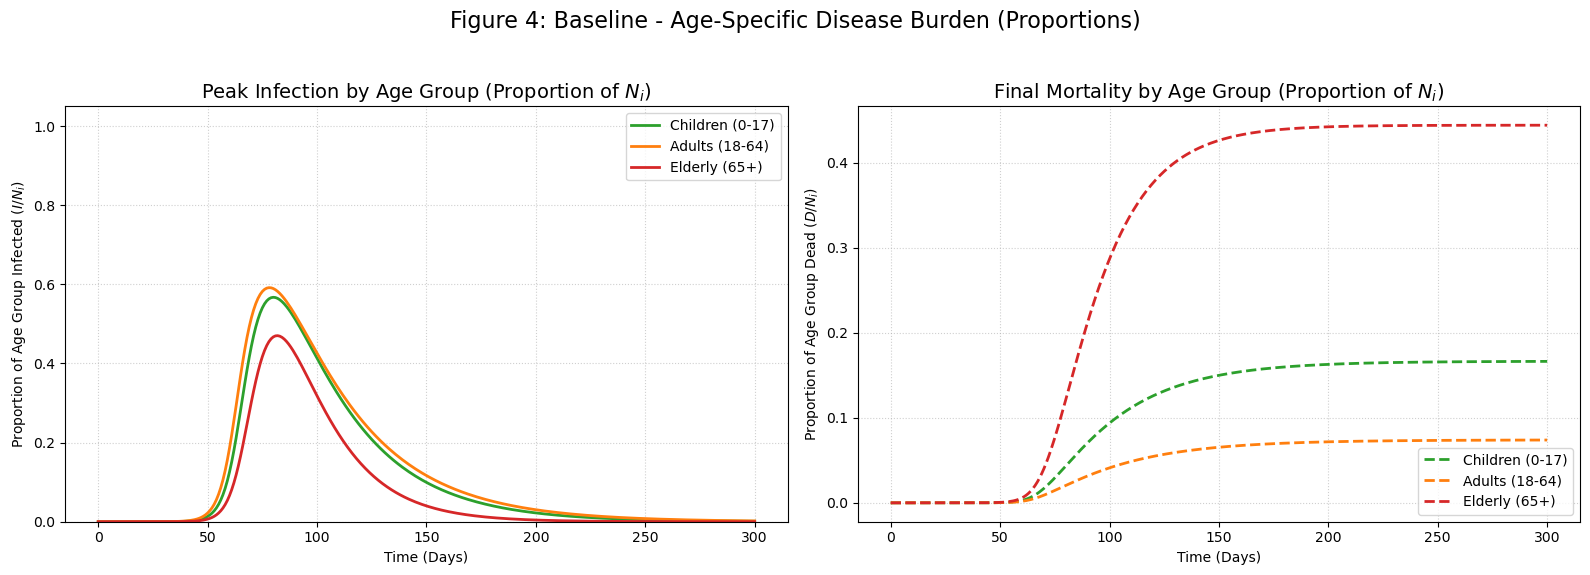

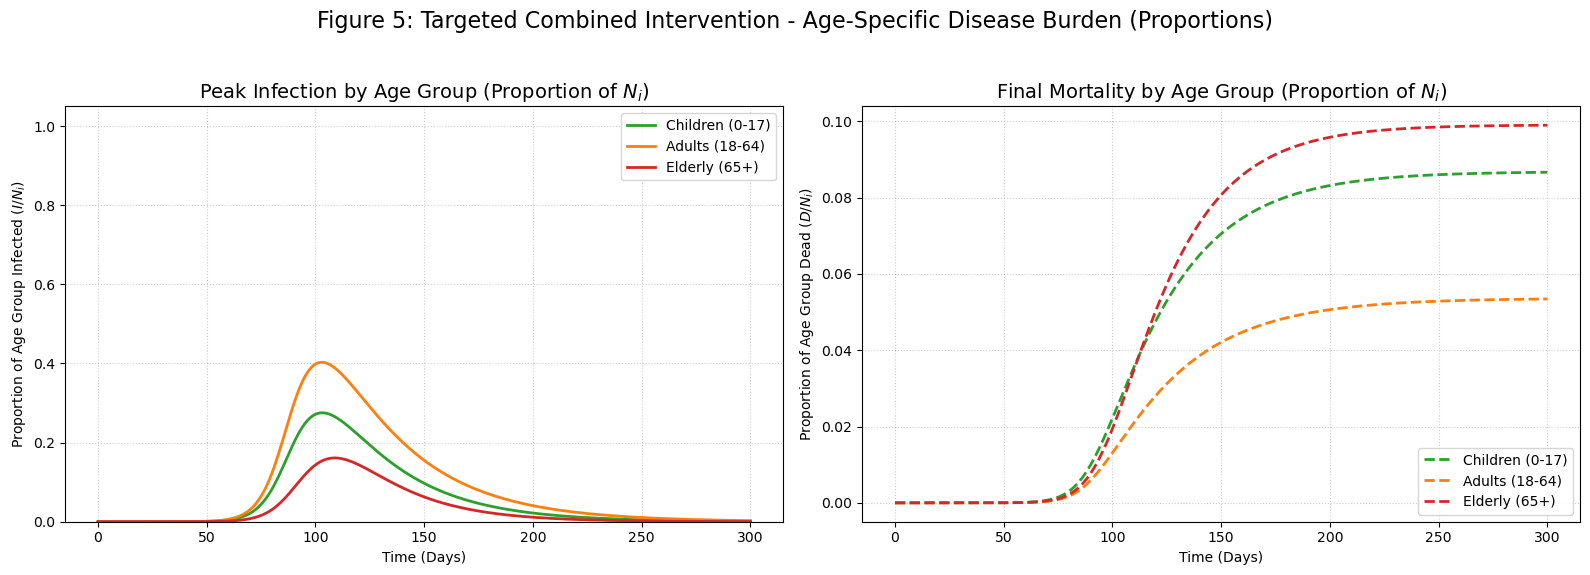


--- Summary of Scenarios ---
Scenario A (Baseline): No interventions.
Scenario B (Targeted): Vax (Adults: 20% coverage * 80% eff = 16% moved from S to R at t=0), Antivirals (Elderly, 50% eff), Distancing (Adults, 20% reduction).


In [37]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# --- 1. Model Setup and Parameters ---

# 🌎 Population Structure
N_ages = 3  
age_labels = ['Children (0-17)', 'Adults (18-64)', 'Elderly (65+)']
compartment_labels = ['Susceptible (S)', 'Exposed (E)', 'Infectious (I)', 'Recovered (R)', 'Deceased (D)']
N_initial = np.array([1246100, 3757100, 953500]) # Absolute Initial Population Sizes
Total_Population_initial = np.sum(N_initial)

# Epidemiological Parameters
beta = 0.05      
sigma = 0.1   
gamma = 0.025  
mu_age = np.array([0.005, 0.002, 0.02]) 

# Contact Matrix (C)
C = np.array([
    [10.0, 5.0, 2.0], 
    [5.0, 15.0, 3.0], 
    [2.0, 3.0, 6.0]   
])

t_span = (0, 300)
t_eval = np.linspace(t_span[0], t_span[1], 301)


# --- 2. THE CORE SEIRD Model ODE System (Corrected Indexing) ---

def seird_model(t, y, N_ages, N_initial, C, beta, sigma, gamma, mu_age,
                vax_rate, vax_efficacy, antiviral_efficacy, distancing_factor):
    """
    Age-structured SEIRD model with correct handling of age-group compartments.
    y is a flat vector of length N_ages * 5.
    """
    
    # Compartments S, E, I, R, D are indexed 0, 1, 2, 3, 4 respectively.
    # We slice the flat vector y to get the current state for each compartment across all age groups.
    S = y[0*N_ages : 1*N_ages]
    E = y[1*N_ages : 2*N_ages]
    I = y[2*N_ages : 3*N_ages]
    R = y[3*N_ages : 4*N_ages]
    D = y[4*N_ages : 5*N_ages]

    # Calculate the current living population for each group (S+E+I+R)
    N_current = S + E + I + R

    # 1. Interventions
    vax_flow_rate = np.zeros(N_ages)
    vax_flow_rate = vax_rate * vax_efficacy 
    mu_adj = mu_age * (1.0 - antiviral_efficacy)
    dist_factor_vector = 1.0 - distancing_factor
    dist_matrix = np.outer(dist_factor_vector, dist_factor_vector)
    C_adj = C * dist_matrix 

    # Force of Infection (Lambda_i)
    Lambda = np.zeros(N_ages)
    for i in range(N_ages): # For susceptible group i
        exposure_from_j = 0.0
        for j in range(N_ages): # From infectious group j
            # I[j] / N_safe[j] ensures correct pairing of infected count and its population base.
            exposure_from_j += C_adj[i, j] * (I[j] / N_current[j])
        
        # Susceptibility factor is 1.0 (as vaccinated moved to R at t=0)
        Lambda[i] = beta * exposure_from_j
        
    # ODE System (returns dy/dt as a flat vector)
    dydt = np.zeros(N_ages * 5)
    
    for i in range(N_ages):
        dSi_dt = -Lambda[i] * S[i] -vax_flow_rate[i] * S[i] 
        dEi_dt = Lambda[i] * S[i] - sigma * E[i]
        dIi_dt = sigma * E[i] - gamma * I[i] - mu_adj[i] * I[i]
        dRi_dt = gamma * I[i] + vax_flow_rate[i] * S[i] 
        dDi_dt = mu_adj[i] * I[i]
        
        # Populate the flat dydt vector correctly
        dydt[0*N_ages + i] = dSi_dt
        dydt[1*N_ages + i] = dEi_dt
        dydt[2*N_ages + i] = dIi_dt
        dydt[3*N_ages + i] = dRi_dt
        dydt[4*N_ages + i] = dDi_dt
        
    return dydt


# --- 3. Simulation Function and Scenario Definition ---

def run_simulation(vax_rate_target, vax_efficacy, antiviral_efficacy, distancing_factor, label):
    """Runs one SEIRD simulation with initial condition adjustment for vaccination."""

    # 3a. Base Initial Conditions
    I0 = np.zeros(N_ages); I0[1] = 1.0 # 1 infected Adult
    E0 = np.zeros(N_ages); R0 = np.zeros(N_ages); D0 = np.zeros(N_ages)
    S0 = N_initial - I0 - E0 - R0 - D0 
    
    # Flatten the Initial Conditions (IC) vector: S S S | E E E | I I I | R R R | D D D
    IC_adjusted = np.concatenate([S0, E0, I0, R0, D0])
    
    # 3c. Solve ODE
    solver_args = (N_ages, N_initial, C, beta, sigma, gamma, mu_age,
                   vax_rate_target, vax_efficacy, antiviral_efficacy, distancing_factor)
    
    sol = solve_ivp(
        fun=seird_model, t_span=t_span, y0=IC_adjusted, t_eval=t_eval,
        args=solver_args, method='RK45'
    )
    
    # The output is (N_time x N_groups*5). We now reshape it to (N_time x 5 compartments x N_groups)
    # The previous method using (N_time x N_groups x 5 compartments) was prone to the bug.
    results_abs_flat = sol.y.T
    results_abs_reshaped = np.zeros((len(t_eval), N_ages, 5))

    # CRITICAL FIX: Manually assign the results to the correct [time, group, compartment] indices
    # This prevents the mixing of compartments that caused the I/N > 1 error.
    for k in range(5): # k = compartment index (0=S, 4=D)
        results_abs_reshaped[:, :, k] = results_abs_flat[:, k*N_ages : (k+1)*N_ages]
        
    results_prop_total = results_abs_reshaped.sum(axis=1)[:, 4] / Total_Population_initial # Only Deaths/N_total shown for conciseness

    return {
        't': sol.t, 
        'abs': results_abs_reshaped, # Shape: (Time x Age Group x Compartment)
        'prop_total': results_prop_total,
        'label': label
    }

# --- Define Scenarios ---

# Scenario A: Baseline (No Intervention)
vax_A = np.zeros(N_ages); anti_A = np.zeros(N_ages); dist_A = np.zeros(N_ages)
results_A = run_simulation(vax_A, 0.0, anti_A, dist_A, "Baseline")

# Scenario B-REV: Targeted Combined Intervention
# Assuming 0.03 or 3% of the population is vaccinated per day
vax_B_rev = np.array([0.01, 0.005, 0.015]) 
vax_eff_B_rev = 0.8                   

# Assuming 0.03 or 3% of the population is vaccinated per day
vax_C_rev = np.array([0.015, 0.000, 0.015]) 
vax_eff_C_rev = 0.8                   
anti_C_rev = np.array([0.0, 0.0, 0.5]) 
dist_C_rev = np.array([0.0, 0.2, 0.0]) 

results_B_rev = run_simulation(vax_B_rev, vax_eff_B_rev, anti_B_rev, dist_B_rev, "Targeted Combined Intervention")


# --- 4. Visualization Functions (Generates all 5 requested figures) ---

Compartment_Names = ['Susceptible (S)', 'Exposed (E)', 'Infectious (I)', 'Recovered (R)', 'Deaths (D)']
Colors_comp = ['#2ca02c', '#ff7f0e', '#d62728', '#1f77b4', '#7f7f7f']
Colors_age = ['#2ca02c', '#ff7f0e', '#d62728']

# --- Figure 1: Proportions of TOTAL Population ---
def plot_proportions_total(results_A, results_B):
    fig, (ax1_A, ax1_B) = plt.subplots(1, 2, figsize=(16, 6))
    
    # We must calculate the proportion of total N for all compartments here
    for ax, results_set in zip([ax1_A, ax1_B], [results_A, results_B]):
        total_comp_abs = results_set['abs'].sum(axis=1) # Sums across age groups -> (Time x 5 Compartments)
        total_comp_prop = total_comp_abs / Total_Population_initial
        
        ax.set_title(f'{results_set["label"]} - Total Population Dynamics', fontsize=12)
        ax.set_xlabel('Time (Days)'); ax.set_ylabel('Proportion of Total Initial Population')
        for k in range(5):
            ax.plot(results_set['t'], total_comp_prop[:, k], label=Compartment_Names[k], color=Colors_comp[k])
        ax.legend(loc='center right', fontsize=8); ax.grid(True, linestyle=':', alpha=0.6)
    
    fig.suptitle('Figure 1: Comparison of Overall Epidemic Dynamics (Proportions of Total N)', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()

# --- Figures 2 & 3: Absolute Numbers (I and D) ---
def plot_absolute_details(results_set, fig_num):
    fig, (ax_main, ax_death) = plt.subplots(2, 1, figsize=(8, 10))
    # Top Subplot: Infectious (I) Absolute Numbers
    ax_main.set_title(f'{results_set["label"]} - Absolute Infectious (I) by Age Group', fontsize=12)
    ax_main.set_ylabel('Number of Individuals (Infectious)'); ax_main.set_xlabel('Time (Days)')
    for i in range(N_ages):
        ax_main.plot(results_set['t'], results_set['abs'][:, i, 2], label=age_labels[i], linestyle='-', linewidth=2, color=Colors_age[i])
    ax_main.legend(loc='upper right', fontsize=8); ax_main.grid(True, linestyle=':', alpha=0.6)
    # Bottom Subplot: Cumulative Deaths (D) Absolute Numbers
    ax_death.set_title('Cumulative Deaths (D) by Age Group', fontsize=10)
    ax_death.set_ylabel('Number of Deaths'); ax_death.set_xlabel('Time (Days)')
    for i in range(N_ages):
        ax_death.plot(results_set['t'], results_set['abs'][:, i, 4], label=age_labels[i], linestyle='--', linewidth=1.5, color=Colors_age[i])
    ax_death.legend(loc='lower right', fontsize=8); ax_death.grid(True, linestyle=':', alpha=0.6)
    fig.suptitle(f'Figure {fig_num}: {results_set["label"]} - Absolute Burden by Age', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()

# --- Figures 4 & 5: Age-Specific Proportions (I/N_i and D/N_i) ---
def plot_age_proportions(results_set, N_pop_initial, fig_num):
    """Plots the proportion of each age group that is Infectious (I) and Dead (D)."""
    # The shape of results_set['abs'] is (Time x Age Group x Compartment)
    # The N_pop_initial must be broadcast correctly across the time axis.
    I_prop = results_set['abs'][:, :, 2] / N_pop_initial 
    D_prop = results_set['abs'][:, :, 4] / N_pop_initial

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Subplot 1: Infectious (I) Proportion
    ax1 = axes[0]
    ax1.set_title(f'Peak Infection by Age Group (Proportion of $N_i$)', fontsize=14)
    ax1.set_xlabel('Time (Days)'); ax1.set_ylabel('Proportion of Age Group Infected ($I / N_i$)')
    for i in range(N_ages):
        ax1.plot(results_set['t'], I_prop[:, i], label=age_labels[i], linestyle='-', linewidth=2, color=Colors_age[i])
    ax1.legend(loc='upper right', fontsize=10); ax1.set_ylim(0, 1.05); ax1.grid(True, linestyle=':', alpha=0.6)
    
    # Subplot 2: Cumulative Deaths (D) Proportion
    ax2 = axes[1]
    ax2.set_title(f'Final Mortality by Age Group (Proportion of $N_i$)', fontsize=14)
    ax2.set_xlabel('Time (Days)'); ax2.set_ylabel('Proportion of Age Group Dead ($D / N_i$)')
    for i in range(N_ages):
        ax2.plot(results_set['t'], D_prop[:, i], label=age_labels[i], linestyle='--', linewidth=2, color=Colors_age[i])
    ax2.legend(loc='lower right', fontsize=10); ax2.grid(True, linestyle=':', alpha=0.6)
    
    fig.suptitle(f'Figure {fig_num}: {results_set["label"]} - Age-Specific Disease Burden (Proportions)', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()


# --- 5. Generate All Requested Graphs ---

# Figure 1: Overall Dynamics (Proportion of Total Population)
plot_proportions_total(results_A, results_B_rev)

# Figure 2: Baseline Absolute Numbers
plot_absolute_details(results_A, 2)

# Figure 3: Targeted Absolute Numbers
plot_absolute_details(results_B_rev, 3)

# Figure 4: Baseline Age-Specific Proportions (I/N_i and D/N_i)
plot_age_proportions(results_A, N_initial, 4)

# Figure 5: Targeted Age-Specific Proportions (I/N_i and D/N_i)
plot_age_proportions(results_B_rev, N_initial, 5)

print("\n--- Summary of Scenarios ---")
print("Scenario A (Baseline): No interventions.")
print("Scenario B (Targeted): Vax (Adults: 20% coverage * 80% eff = 16% moved from S to R at t=0), Antivirals (Elderly, 50% eff), Distancing (Adults, 20% reduction).")

Running Sensitivity Analysis (Varying Vax Start Time)...
Running Sensitivity Analysis (Varying Vax Start Time)...


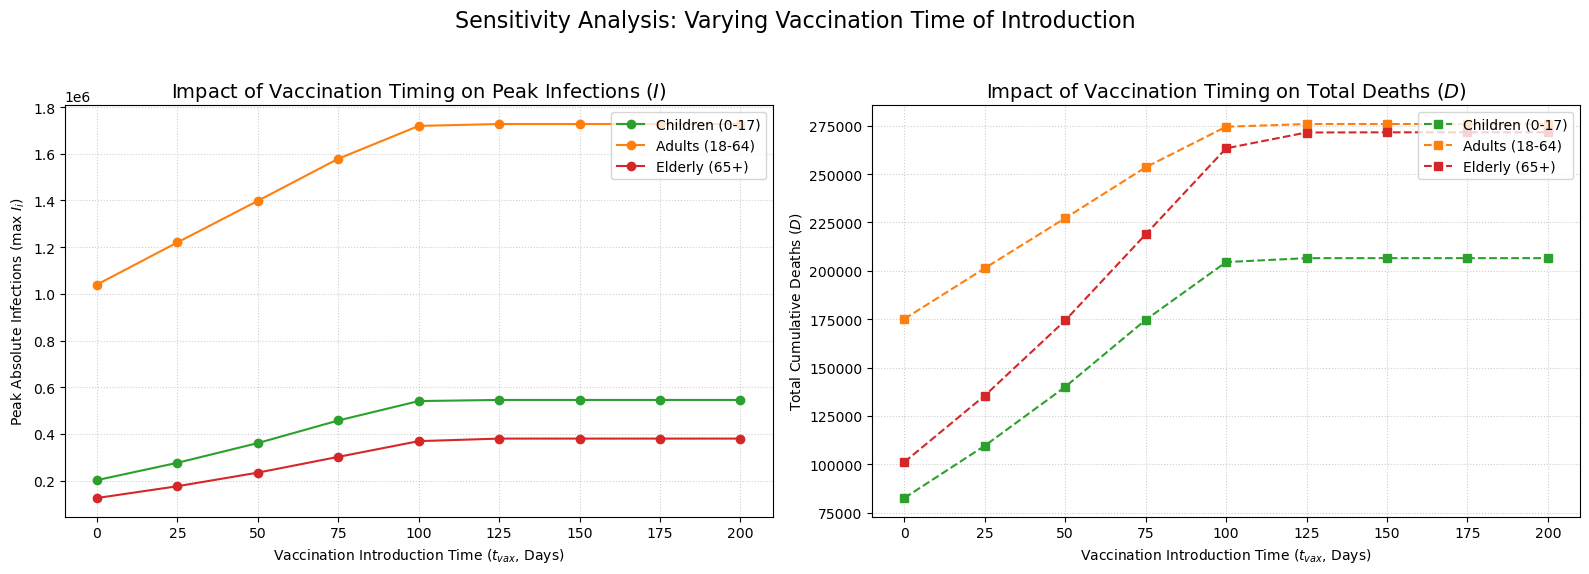


--- Summary of Analysis ---
Analysis shows the impact of delaying vaccination (Adults targeted at rate 0.005/day, Elderly and Children target at rate of 0.01/day, 80% efficacy) on peak infections and total deaths.
The earlier the vaccination starts, the lower the peak infections and total deaths are across all age groups.


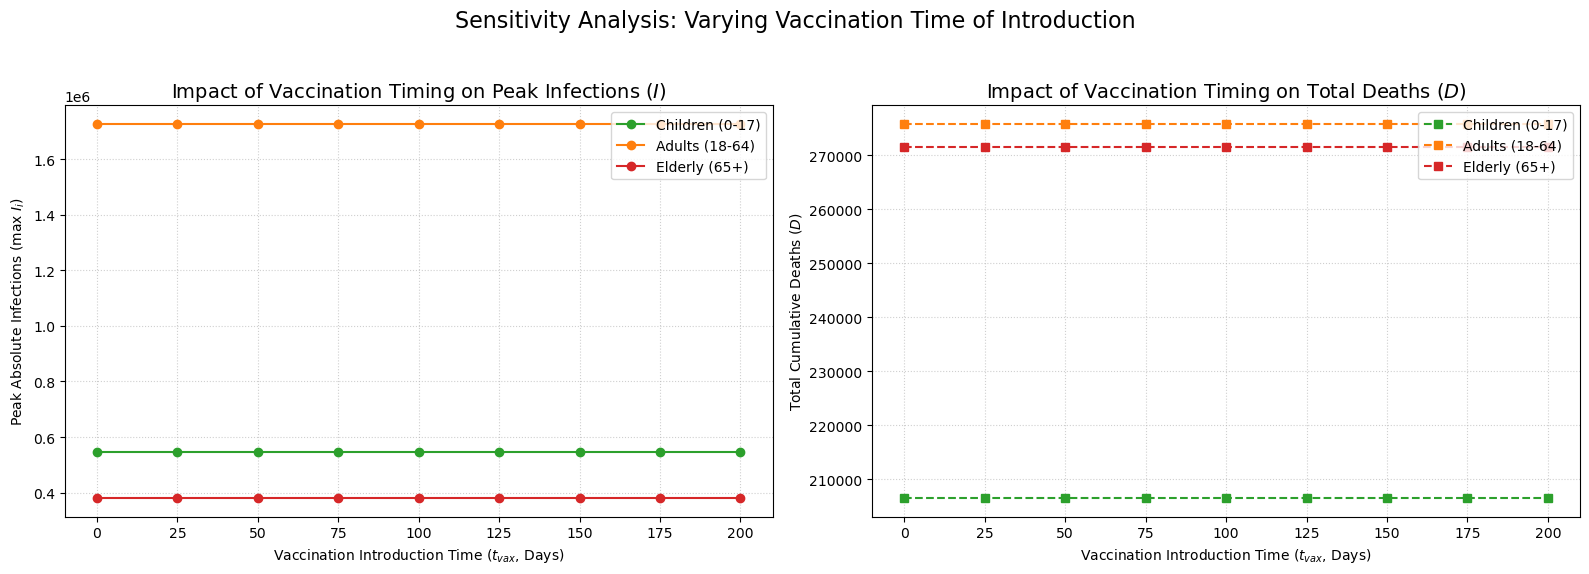

In [35]:

def seird_model(t, y, N_ages, N_initial, C, beta, sigma, gamma, mu_age,
                vax_rate_flow, vax_efficacy, antiviral_efficacy, distancing_factor, vax_start_time):
    """
    Age-structured SEIRD model with dynamic population base and time-dependent vaccination.
    vax_rate_flow is now the constant per-capita rate applied after vax_start_time.
    """
    
    S = y[0*N_ages : 1*N_ages]
    E = y[1*N_ages : 2*N_ages]
    I = y[2*N_ages : 3*N_ages]
    R = y[3*N_ages : 4*N_ages]
    D = y[4*N_ages : 5*N_ages]

    N_current = S + E + I + R

    # --- Time-Dependent Vaccination Rate ---
    vax_flow_rate = np.zeros(N_ages)
    if t >= vax_start_time:
        # Rate of flow from S to R (per person per day)
        # Note: We assume the flow rate accounts for efficacy: flow = vax_rate * vax_efficacy
        vax_flow_rate = vax_rate_flow * vax_efficacy 

    # 1. Interventions
    mu_adj = mu_age * (1.0 - antiviral_efficacy)
    dist_factor_vector = 1.0 - distancing_factor
    dist_matrix = np.outer(dist_factor_vector, dist_factor_vector)
    C_adj = C * dist_matrix 

    # Force of Infection (Lambda_i)
    Lambda = np.zeros(N_ages)
    for i in range(N_ages): 
        exposure_from_j = 0.0
        for j in range(N_ages): 
            exposure_from_j += C_adj[i, j] * (I[j] / N_current[j])
        Lambda[i] = beta * exposure_from_j
        
    # ODE System 
    dydt = np.zeros(N_ages * 5)
    
    for i in range(N_ages):
        dSi_dt = -Lambda[i] * S[i] - vax_flow_rate[i] * S[i]
        dEi_dt = Lambda[i] * S[i] - sigma * E[i]
        dIi_dt = sigma * E[i] - gamma * I[i] - mu_adj[i] * I[i]
        dRi_dt = gamma * I[i] + vax_flow_rate[i] * S[i]  # Vaccination flow adds to R
        dDi_dt = mu_adj[i] * I[i]
        
        dydt[0*N_ages + i] = dSi_dt
        dydt[1*N_ages + i] = dEi_dt
        dydt[2*N_ages + i] = dIi_dt
        dydt[3*N_ages + i] = dRi_dt
        dydt[4*N_ages + i] = dDi_dt
        
    return dydt


# --- 3. Simulation Function (Simplified IC) ---

def run_simulation(vax_rate_flow, vax_efficacy, antiviral_efficacy, distancing_factor, vax_start_time):
    """Runs one SEIRD simulation and returns time, absolute results, and label."""
    
    # Simple Initial Conditions (IC) setup: No t=0 vax
    I0 = np.zeros(N_ages); I0[1] = 1.0 
    E0 = np.zeros(N_ages); R0 = np.zeros(N_ages); D0 = np.zeros(N_ages)
    S0 = N_initial - I0 - E0 - R0 - D0 
    IC = np.concatenate([S0, E0, I0, R0, D0])
    
    solver_args = (N_ages, N_initial, C, beta, sigma, gamma, mu_age,
                   vax_rate_flow, vax_efficacy, antiviral_efficacy, distancing_factor, vax_start_time)
    
    sol = solve_ivp(
        fun=seird_model, t_span=t_span, y0=IC, t_eval=t_eval,
        args=solver_args, method='RK45'
    )
    
    results_abs_flat = sol.y.T
    results_abs_reshaped = np.zeros((len(t_eval), N_ages, 5))
    for k in range(5):
        results_abs_reshaped[:, :, k] = results_abs_flat[:, k*N_ages : (k+1)*N_ages]

    return results_abs_reshaped


# --- 4. Sensitivity Analysis: Varying Vaccination Start Time ---

def sensitivity_analysis_vax_time(vax_rate, vax_eff, anti_eff, dist_factor):
    """
    Runs simulations for a range of vaccination start times (t_vax)
    and collects peak infections and final deaths.
    """
    # Range of Vax Start Times (Days 0 to 200)
    vax_start_times = np.arange(0, 201, 25) 
    
    # Results storage: Peak I and Final D for each group, for each start time.
    # Shape: (N_start_times x N_ages)
    peak_I_by_group = np.zeros((len(vax_start_times), N_ages))
    final_D_by_group = np.zeros((len(vax_start_times), N_ages))

    print("Running Sensitivity Analysis (Varying Vax Start Time)...")

    for idx, t_vax in enumerate(vax_start_times):
        # Run simulation with fixed intervention parameters but varying start time
        results = run_simulation(vax_rate, vax_eff, anti_eff, dist_factor, t_vax)
        
        # Calculate Peak I (max across time, for each group)
        peak_I_by_group[idx, :] = np.max(results[:, :, 2], axis=0)
        
        # Calculate Final D (last value in time, for each group)
        final_D_by_group[idx, :] = results[-1, :, 4]
        
    return vax_start_times, peak_I_by_group, final_D_by_group

# Define fixed intervention scenario (Adults are targeted)
# Vax rate is the per-capita rate: 0.025/day (achieving ~50% coverage over 20 days if S stays constant)
vax_rate_flow_target = np.array([0.01, 0.005, 0.01])  
vax_eff_target = 0.8                   
anti_eff_target = np.array([0.0, 0.0, 0.5]) 
dist_factor_target = np.array([0.0, 0.2, 0.0]) 

vax_rate_flow_target_none = np.array([0,0,0])  

# Run the analysis
t_vax_range, peak_I, final_D = sensitivity_analysis_vax_time(
    vax_rate_flow_target, vax_eff_target, anti_eff_target, dist_factor_target
)

t_vax_range_none, peak_I_none, final_D_none = sensitivity_analysis_vax_time(
    vax_rate_flow_target_none, vax_eff_target, anti_eff_target, dist_factor_target
)


# --- 5. Visualization of Sensitivity Analysis ---

Colors_age = ['#2ca02c', '#ff7f0e', '#d62728']

def plot_sensitivity_results(t_range, peak_I, final_D):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # --- Subplot 1: Peak Infectious (I) ---
    ax1 = axes[0]
    ax1.set_title('Impact of Vaccination Timing on Peak Infections ($I$)', fontsize=14)
    ax1.set_xlabel('Vaccination Introduction Time ($t_{vax}$, Days)')
    ax1.set_ylabel('Peak Absolute Infections (max $I_i$)')
    
    for i in range(N_ages):
        ax1.plot(t_range, peak_I[:, i], 
                 label=age_labels[i], marker='o', linestyle='-', color=Colors_age[i])
        
    ax1.legend(loc='upper right', fontsize=10)
    ax1.grid(True, linestyle=':', alpha=0.6)
    
    # --- Subplot 2: Total Deaths (D) ---
    ax2 = axes[1]
    ax2.set_title('Impact of Vaccination Timing on Total Deaths ($D$)', fontsize=14)
    ax2.set_xlabel('Vaccination Introduction Time ($t_{vax}$, Days)')
    ax2.set_ylabel('Total Cumulative Deaths ($D$)')
    
    for i in range(N_ages):
        ax2.plot(t_range, final_D[:, i], 
                 label=age_labels[i], marker='s', linestyle='--', color=Colors_age[i])
        
    ax2.legend(loc='upper right', fontsize=10)
    ax2.grid(True, linestyle=':', alpha=0.6)
    
    fig.suptitle('Sensitivity Analysis: Varying Vaccination Time of Introduction', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Run the visualization
plot_sensitivity_results(t_vax_range, peak_I, final_D)

print("\n--- Summary of Analysis ---")
print(f"Analysis shows the impact of delaying vaccination (Adults targeted at rate 0.005/day, Elderly and Children target at rate of 0.01/day, 80% efficacy) on peak infections and total deaths.")
print("The earlier the vaccination starts, the lower the peak infections and total deaths are across all age groups.")

plot_sensitivity_results(t_vax_range_none, peak_I_none, final_D_none)

<>:18: SyntaxWarning: invalid escape sequence '\s'
<>:24: SyntaxWarning: invalid escape sequence '\s'
<>:18: SyntaxWarning: invalid escape sequence '\s'
<>:24: SyntaxWarning: invalid escape sequence '\s'
/var/folders/fm/j_yg06_n4dxddvg9rrqmyrvr0000gn/T/ipykernel_24677/560872589.py:18: SyntaxWarning: invalid escape sequence '\s'
  ax1.set_ylabel('Total Infectious Cases ($\sum I_i$)')
/var/folders/fm/j_yg06_n4dxddvg9rrqmyrvr0000gn/T/ipykernel_24677/560872589.py:24: SyntaxWarning: invalid escape sequence '\s'
  ax2.set_ylabel('Total Cumulative Deaths ($\sum D_i$)')


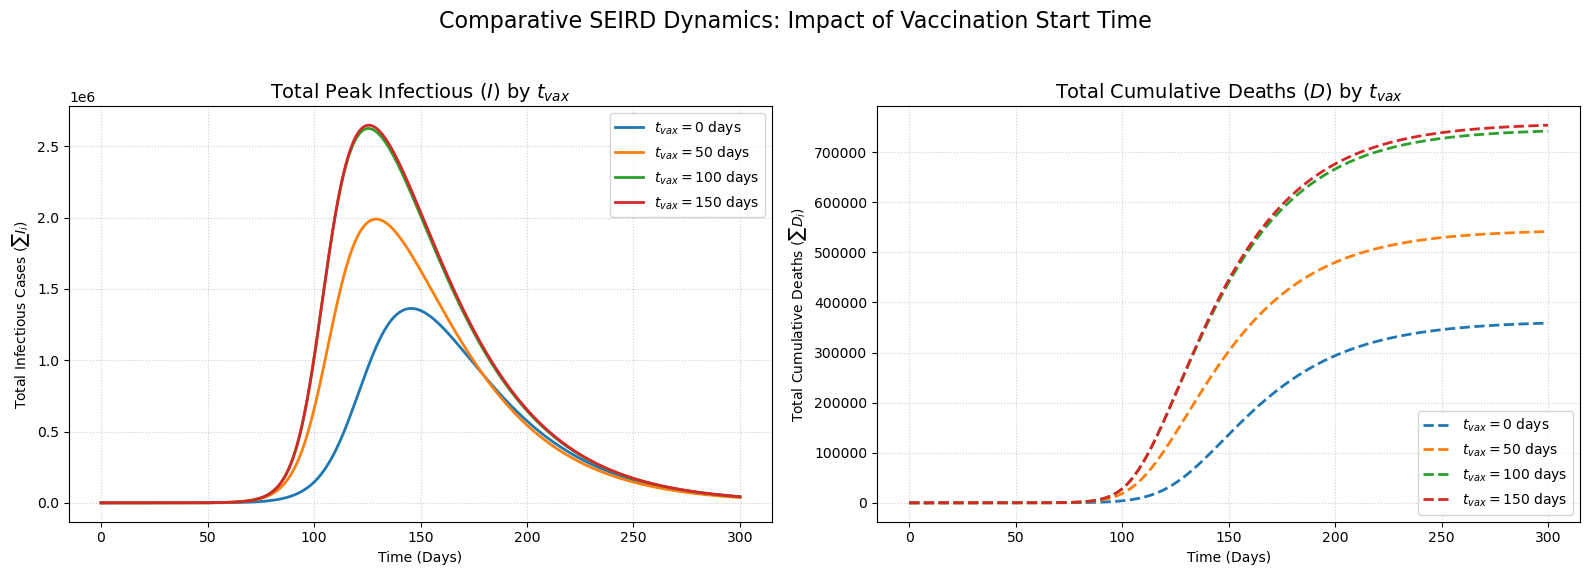

In [34]:
# --- 6. Comparative Visualization of SEIRD Trajectories ---

def plot_comparative_dynamics(t_vax_list, vax_rate, vax_eff, anti_eff, dist_factor):
    """
    Runs and plots total I and total D for selected vaccination start times.
    """
    
    # 2 is the index for I (Infectious), 4 is the index for D (Deaths)
    I_idx = 2
    D_idx = 4
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # --- Subplot 1: Total Infectious (I) ---
    ax1 = axes[0]
    ax1.set_title('Total Peak Infectious ($I$) by $t_{vax}$', fontsize=14)
    ax1.set_xlabel('Time (Days)')
    ax1.set_ylabel('Total Infectious Cases ($\sum I_i$)')
    
    # --- Subplot 2: Total Deaths (D) ---
    ax2 = axes[1]
    ax2.set_title('Total Cumulative Deaths ($D$) by $t_{vax}$', fontsize=14)
    ax2.set_xlabel('Time (Days)')
    ax2.set_ylabel('Total Cumulative Deaths ($\sum D_i$)')

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#ffd343', '#808080'] # Blue, Orange, Green, Red, Yellopw, Grey

    for idx, t_vax in enumerate(t_vax_list):
        # Run simulation
        results = run_simulation(vax_rate, vax_eff, anti_eff, dist_factor, t_vax)
        
        # Calculate Total I (sum across all age groups at each time point)
        Total_I = np.sum(results[:, :, I_idx], axis=1)
        # Calculate Total D (sum across all age groups at each time point)
        Total_D = np.sum(results[:, :, D_idx], axis=1)
        
        label = f'$t_{{vax}} = {t_vax}$ days'
        
        # Plot I
        ax1.plot(t_eval, Total_I, label=label, color=colors[idx], linewidth=2)
        
        # Plot D
        ax2.plot(t_eval, Total_D, label=label, color=colors[idx], linestyle='--', linewidth=2)

    ax1.legend(loc='upper right', fontsize=10)
    ax1.grid(True, linestyle=':', alpha=0.6)
    ax2.legend(loc='lower right', fontsize=10)
    ax2.grid(True, linestyle=':', alpha=0.6)
    
    fig.suptitle('Comparative SEIRD Dynamics: Impact of Vaccination Start Time', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Define the four comparison scenarios
t_vax_comparison = [0, 50, 100, 150]

# Run the comparative visualization
plot_comparative_dynamics(
    t_vax_comparison, vax_rate_flow_target, vax_eff_target, anti_eff_target, dist_factor_target
)

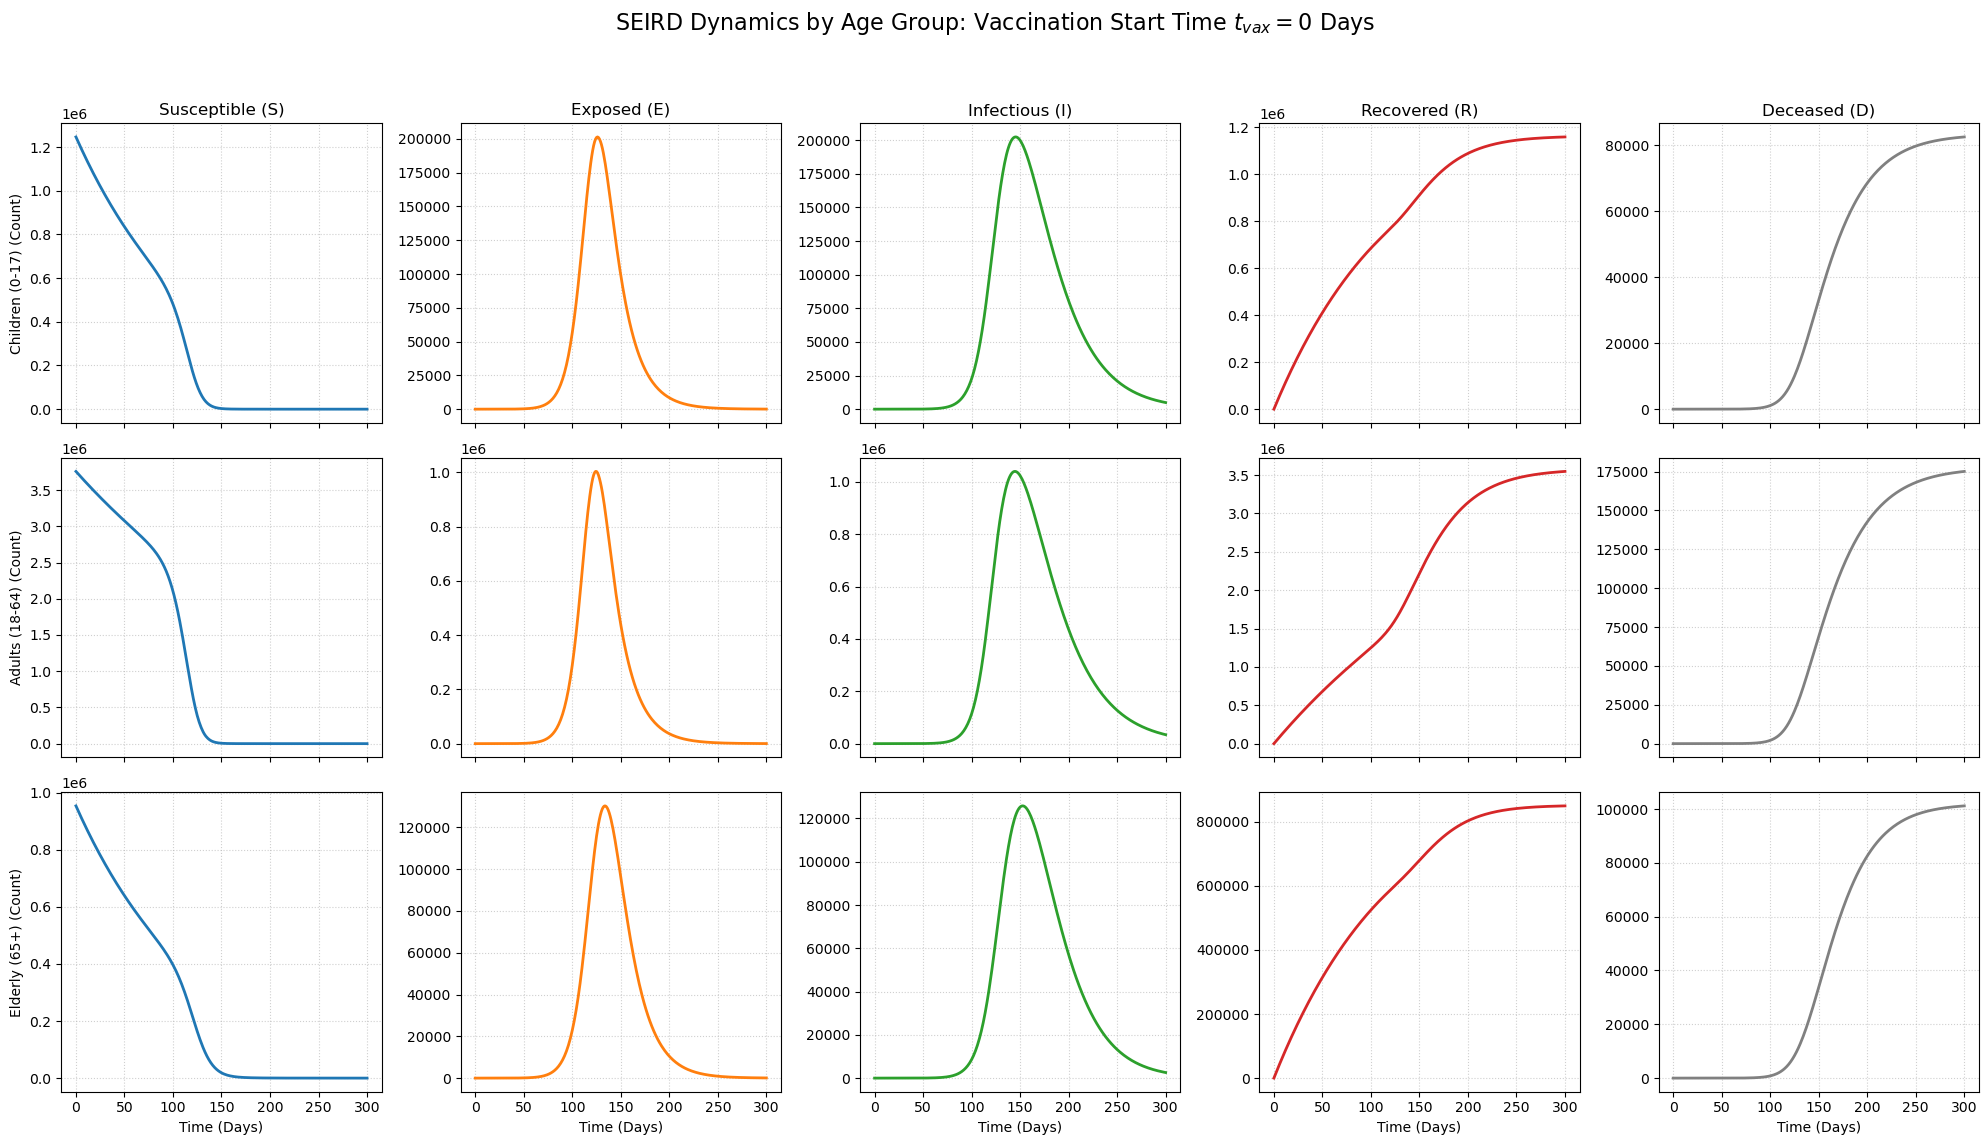

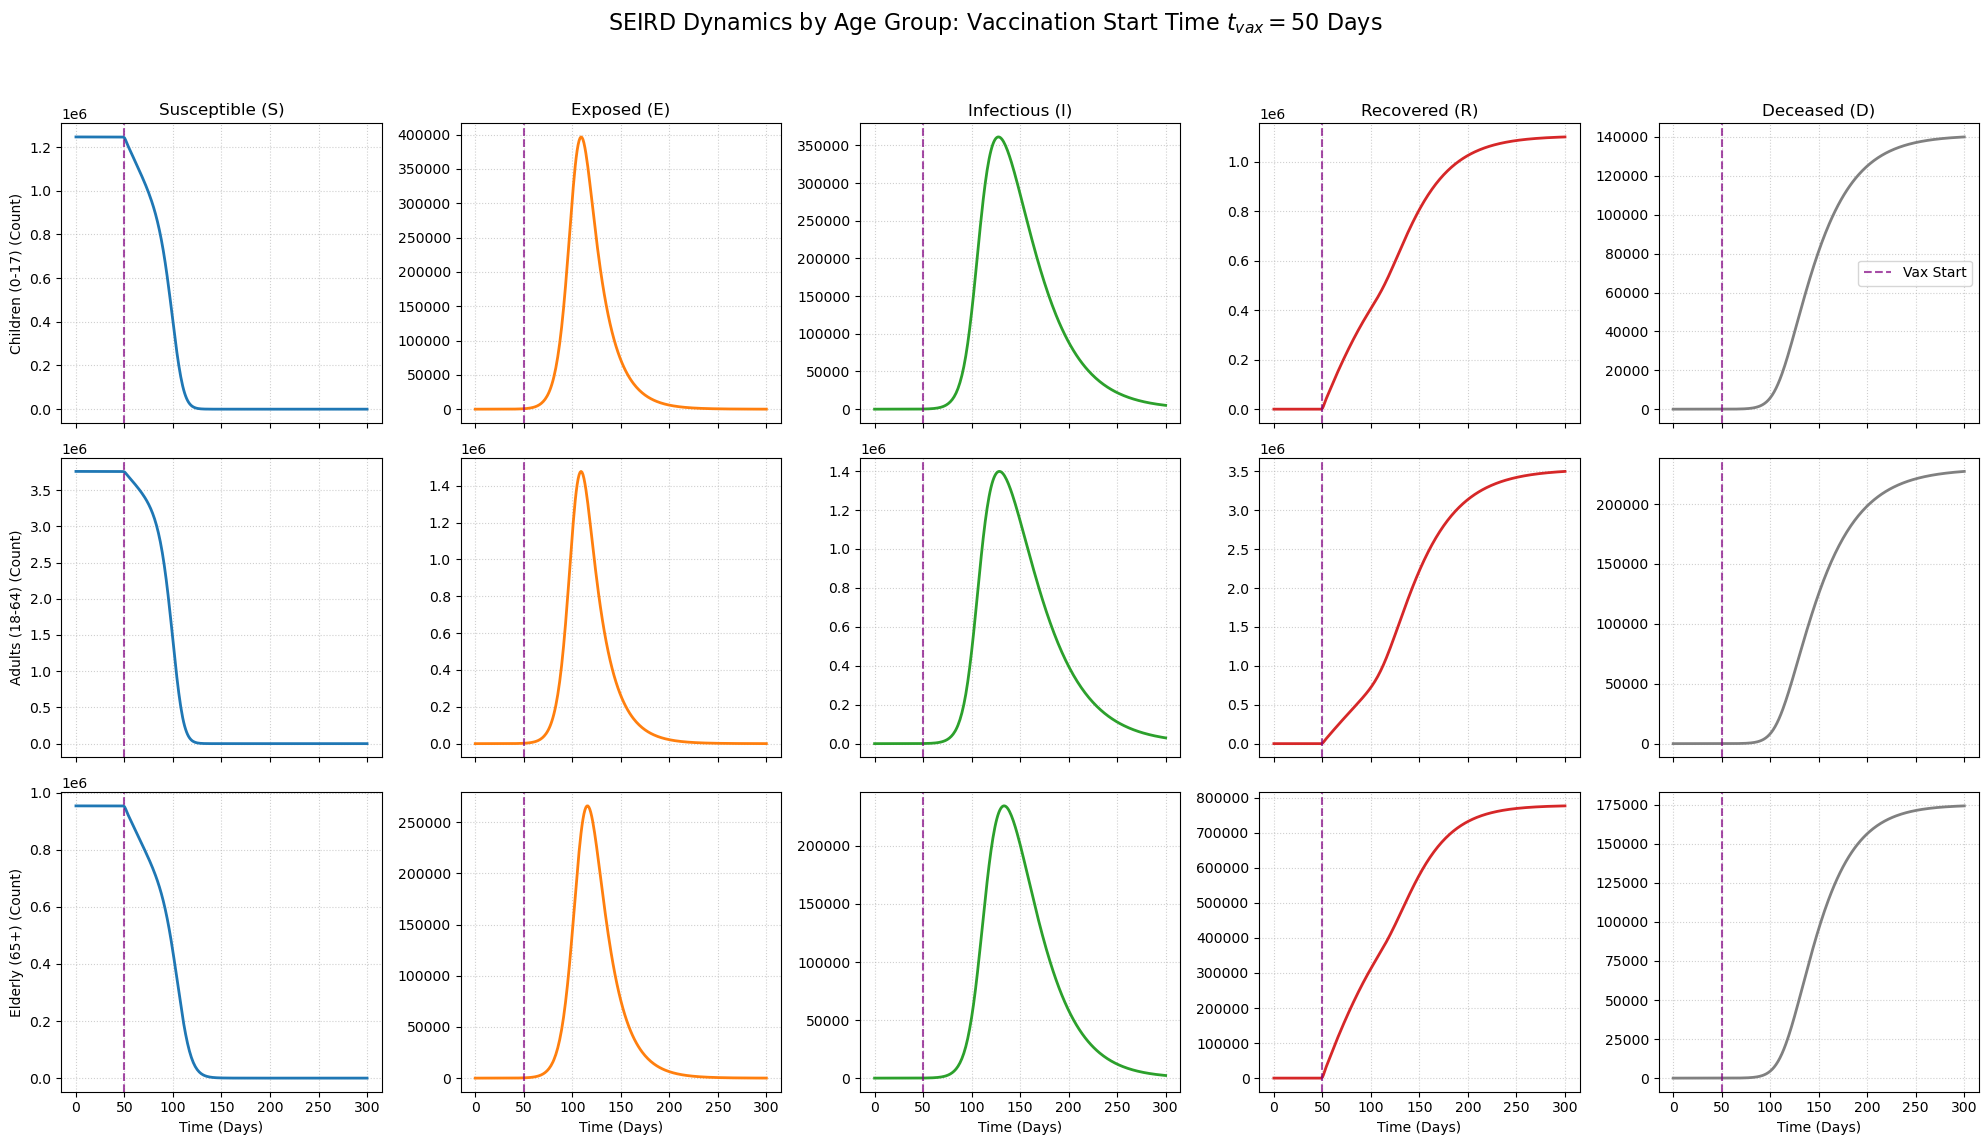

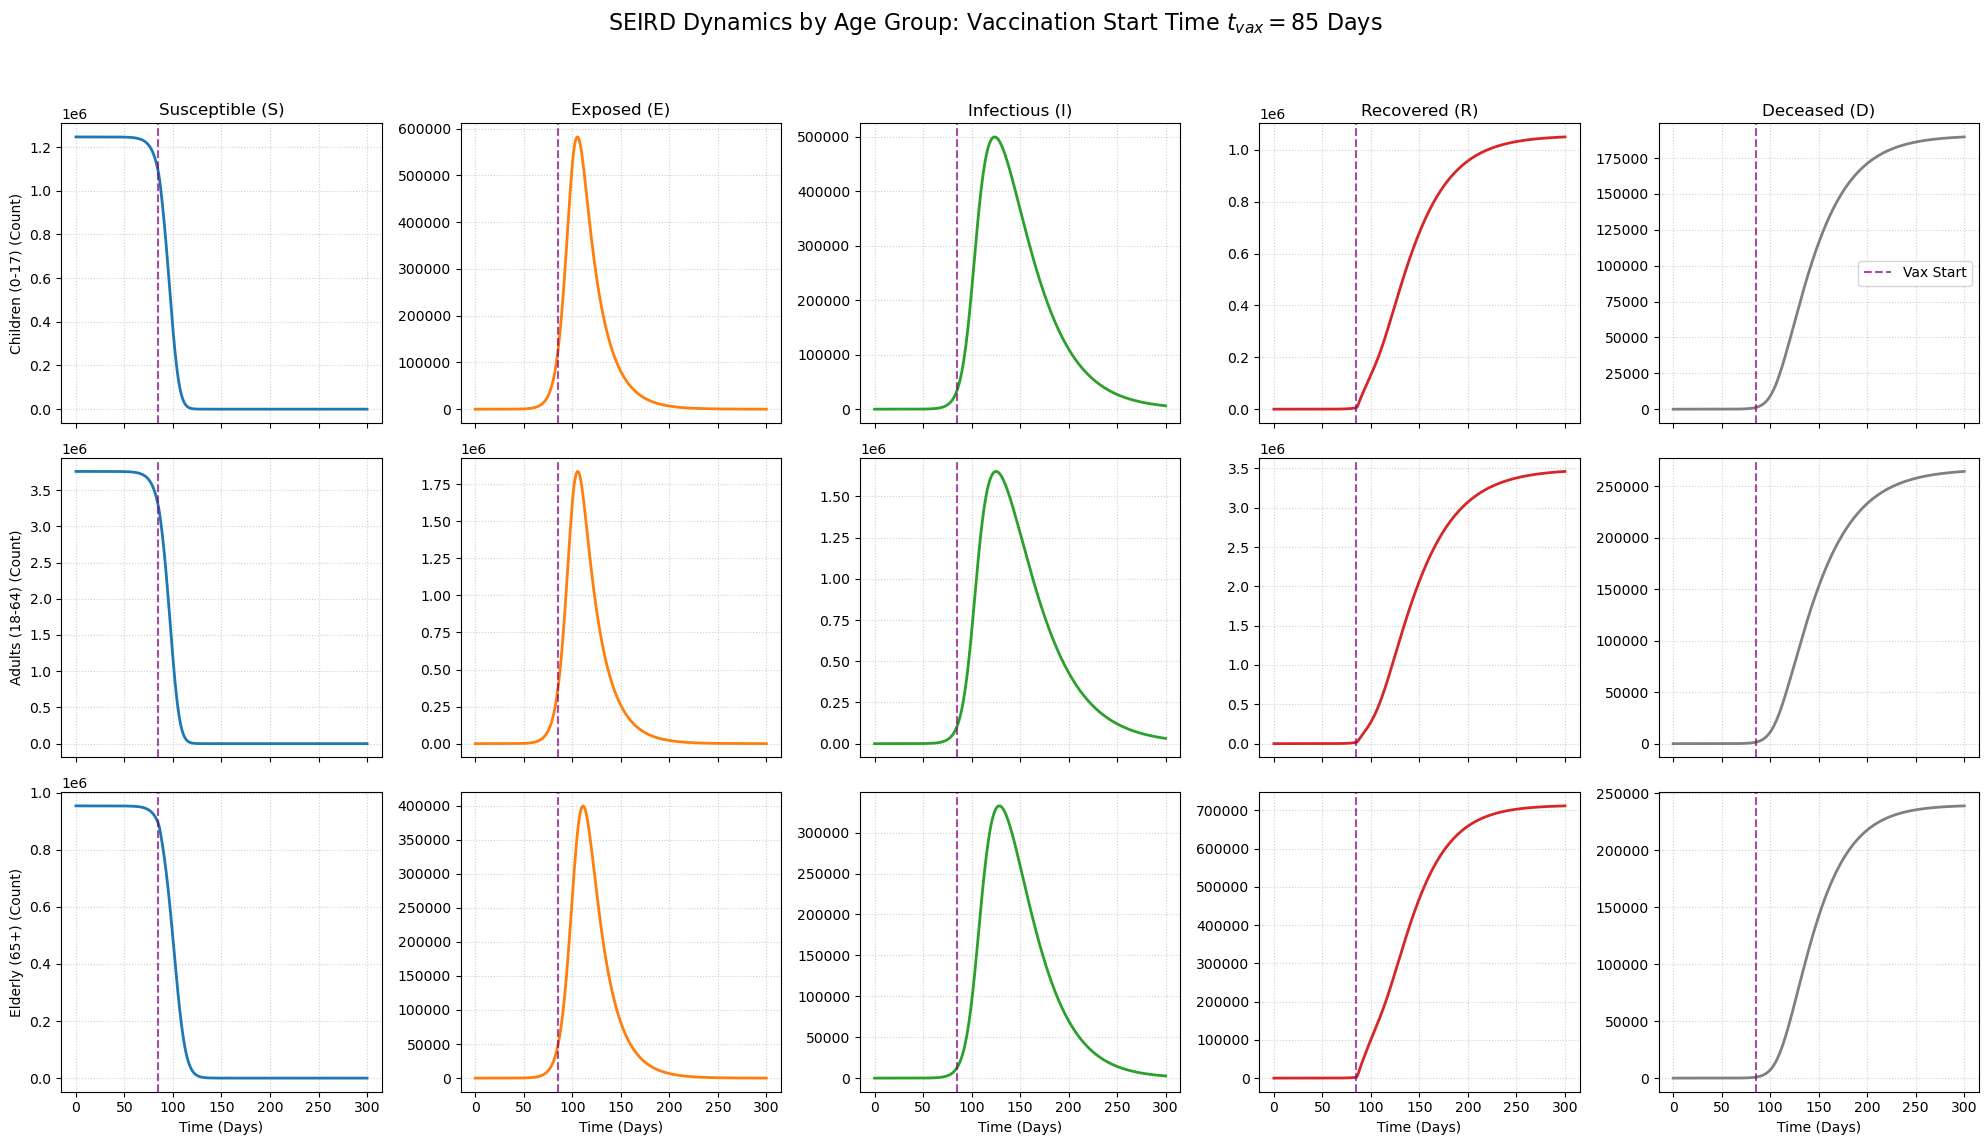

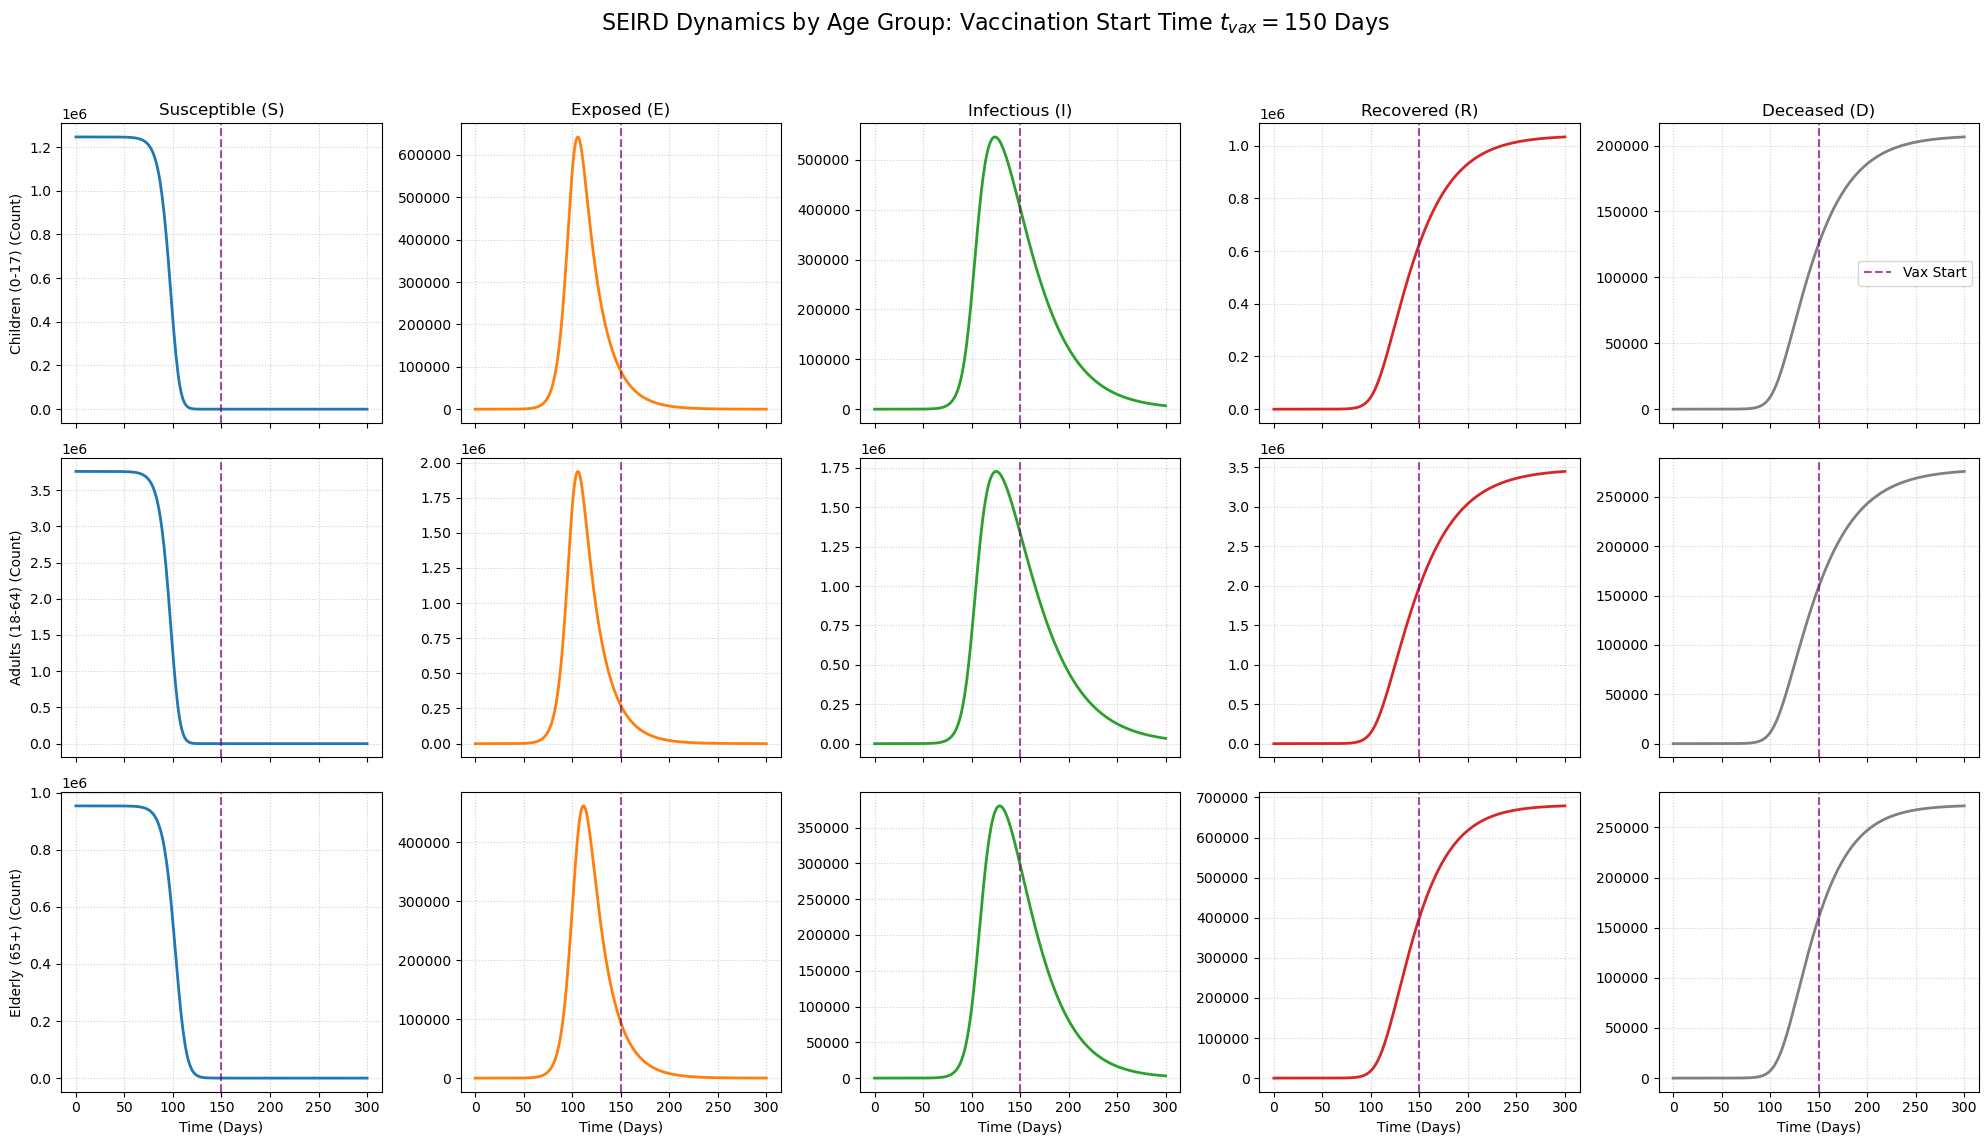

In [36]:
def plot_seird_by_age_group(t_vax, vax_rate, vax_eff, anti_eff, dist_factor, age_labels, compartment_labels):
    """
    Runs one simulation and plots the SEIRD dynamics for each age group.
    """
    
    # Run the simulation for the specified t_vax
    results = run_simulation(vax_rate, vax_eff, anti_eff, dist_factor, t_vax)
    
    # results shape: (time, N_ages, 5 compartments)
    
    # 3 rows (age groups), 5 columns (compartments)
    fig, axes = plt.subplots(N_ages, 5, figsize=(20, 12), sharex=True)
    
    # Colors for the compartments (S, E, I, R, D)
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#808080'] # Blue, Orange, Green, Red, Gray

    for i in range(N_ages): # Loop over age groups (rows)
        for k in range(5): # Loop over compartments (columns)
            ax = axes[i, k]
            
            # Plot the time series for this age group and compartment
            data = results[:, i, k]
            ax.plot(t_eval, data, color=colors[k], linewidth=2)
            
            # Set titles and labels
            if i == 0:
                ax.set_title(f'{compartment_labels[k]}', fontsize=12)
            
            if k == 0:
                ax.set_ylabel(f'{age_labels[i]} (Count)', fontsize=10)
            
            if i == N_ages - 1:
                ax.set_xlabel('Time (Days)', fontsize=10)

            # Add grid for readability
            ax.grid(True, linestyle=':', alpha=0.6)
            
            # Add a vertical line for vaccination start time
            if t_vax > 0:
                ax.axvline(x=t_vax, color='purple', linestyle='--', alpha=0.7, label='Vax Start')
            
            # Optional: Add legend to the first plot in the row
            if k == 4 and i == 0:
                if t_vax > 0:
                    ax.legend(loc='center right')
                
    fig.suptitle(f'SEIRD Dynamics by Age Group: Vaccination Start Time $t_{{vax}} = {t_vax}$ Days', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
    # # Save the figure
    # filename = f'seird_dynamics_tvax_{t_vax}.png'
    # plt.savefig(filename)
    # plt.close(fig)
    # return filename

# --- 7. Execution of Comparative SEIRD Dynamics Plotting ---

t_vax_comparison = [0, 50, 85, 150]
filenames = []

# Re-run the plotting function for each t_vax scenario
for t_vax in t_vax_comparison:
    filename = plot_seird_by_age_group(
        t_vax, vax_rate_flow_target, vax_eff_target, anti_eff_target, dist_factor_target, age_labels, compartment_labels
    )
    filenames.append(filename)

# print("Generated files:", filenames)